In [1]:
import os
import argparse
import functools

from bboxes_utils import bboxes_from_fast_rcnn
from svhn_augmentations import to_tuple

os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

import numpy as np
import tensorflow as tf
from tqdm.auto import tqdm

DIM = 224

from svhn_dataset import SVHN
from lovely_numpy import lo as _lo
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from svhn_competition import create_anchors, RetinaNet
from bboxes_utils import bboxes_iou



def lo(x):
    if isinstance(x, tf.Tensor):
        x = x.numpy()

    return _lo(x)


In [2]:
svhn = SVHN()

Metal device set to: Apple M1 Max


In [3]:
def area_to_w_h(area):
    w = np.sqrt(area / 2)
    h = area / w
    return w, h

In [4]:
rnet = RetinaNet(num_classes=SVHN.LABELS, args=argparse.Namespace(backbone="resnet", heads=(2, 4), dim=224))
anchors = create_anchors(rnet.sizes, rnet.anchor_areas, dim=224)

In [5]:
b = anchors
tf.stack([(b[..., 2] - b[..., 0]) , (b[..., 3] - b[..., 1])], axis=1)

<tf.Tensor: shape=(37044, 2), dtype=float32, numpy=
array([[ 22.627417,  11.313708],
       [ 22.627419,  11.313708],
       [ 22.627419,  11.313708],
       ...,
       [ 71.837585, 143.67516 ],
       [ 71.837585, 143.67516 ],
       [ 71.837585, 143.67516 ]], dtype=float32)>

In [8]:
rnet.anchor_areas

ListWrapper([256, 1024, 4096])

In [9]:
datasets = {
    'train': svhn.train.map(to_tuple),
    'dev': svhn.dev.map(to_tuple),
    'test': svhn.test.map(to_tuple),
}


In [10]:
hs, ws = [], []

for x, _, _ in tqdm(datasets['test']):
    hs.append(x.shape[0])
    ws.append(x.shape[1])

  0%|          | 0/4535 [00:00<?, ?it/s]

In [11]:
np.max(hs), np.max(ws)

(300, 300)

In [29]:
ious = []
ious_idx = []

for k, d in {k: v for k, v in datasets.items() if k in {'train', 'dev'}}.items():
    for x, c, b in tqdm(d):
        _ious = bboxes_iou(b[:, tf.newaxis, ...], anchors[tf.newaxis, ...])
        ious.extend(tf.reduce_max(_ious, 1).numpy().tolist())
        ious_idx.extend(tf.argmax(_ious, 1).numpy().tolist())

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1267 [00:00<?, ?it/s]

(array([2.0000e+00, 3.0000e+00, 1.5000e+01, 8.3000e+01, 3.8200e+02,
        1.9410e+03, 8.7240e+03, 1.0219e+04, 3.0950e+03, 3.3200e+02]),
 array([0.18776749, 0.26854008, 0.34931267, 0.43008527, 0.51085786,
        0.59163045, 0.67240304, 0.75317564, 0.83394823, 0.91472082,
        0.99549341]),
 <BarContainer object of 10 artists>)

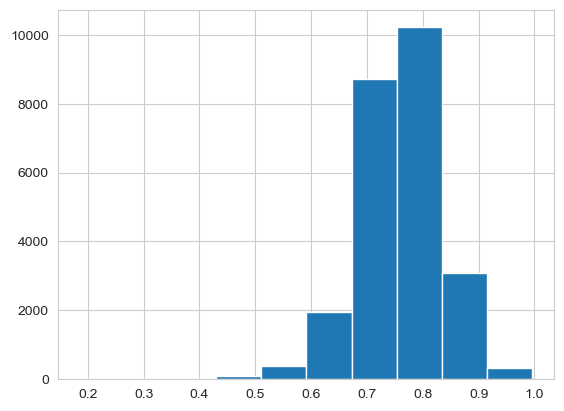

In [30]:
plt.hist(ious)

In [21]:
areas = []
ratios = []
widths = []
heights = []
types = []
for k, d in datasets.items():
    for x, c, b in tqdm(d):
        b = b.numpy()
        areas.extend((b[..., 2] - b[..., 0]) * (b[..., 3] - b[..., 1]))
        ratios.extend((b[..., 2] - b[..., 0]) / (b[..., 3] - b[..., 1]))
        widths.extend(b[..., 3] - b[..., 1])
        heights.extend(b[..., 2] - b[..., 0])
        types.extend([k for _ in range(b.shape[0])])

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1267 [00:00<?, ?it/s]

  0%|          | 0/4535 [00:00<?, ?it/s]

In [22]:
len(anchors)

37044

In [23]:
b = anchors.numpy()
areas.extend((b[..., 2] - b[..., 0]) * (b[..., 3] - b[..., 1]))
ratios.extend((b[..., 2] - b[..., 0]) / (b[..., 3] - b[..., 1]))
widths.extend(b[..., 3] - b[..., 1])
heights.extend(b[..., 2] - b[..., 0])
types.extend(['anchor' for _ in range(b.shape[0])])

In [24]:
df = pd.DataFrame({'area': areas, 'ratio': ratios, 'width': widths, 'height': heights, 'type': types})

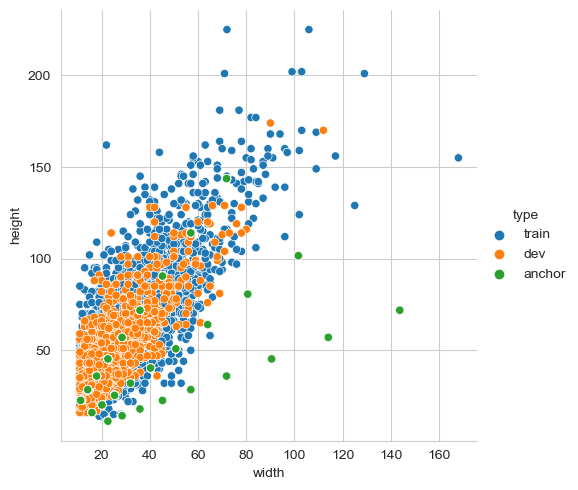

In [27]:
sns.relplot(data=df, y='height', x='width', hue='type', kind='scatter')
plt.show()

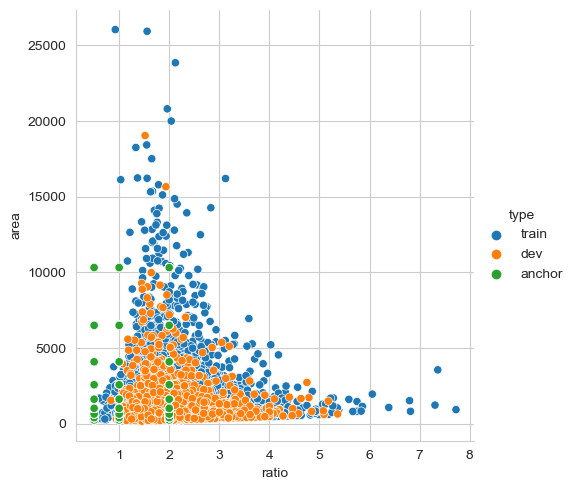

In [28]:
sns.relplot(data=df, y='area', x='ratio', hue='type', kind='scatter')
plt.show()

In [ ]:
df.area.hist(bins=150)

In [ ]:
df.ratio.hist(bins=150)

In [ ]:
np.arange(0, 1, 0.1)

In [ ]:
[2 ** i for i in range(7, 12)]

In [ ]:
[("%0.1f"%v, df.query("type == 'train'").area.quantile(v)) for v in np.arange(0, 1, 0.1)]

In [ ]:
df.area.max()

In [ ]:
[("%0.1f"%v, df.query("type == 'train'").ratio.quantile(v)) for v in np.arange(0, 1, 0.1)]

In [ ]:
x, y = np.histogram(df.ratio)
x, y